In [2]:

import pandas as pd
import geopandas as gpd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 
import datetime as dt 
from pandas import Timestamp
import re
import urllib
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
df = pd.read_csv(r'ctg-studies.csv', sep=',', parse_dates=True)

In [549]:
df.sample(7)

,NCT Number,Study Title,Study URL,Study Status,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Sponsor,Collaborators,Sex,Age,Funder Type,Study Type,Start Date,Completion Date,Locations,TimePassed,Bin
5219,NCT03216473,Clinical Study to Evaluate the Efficacy and Sa...,https://clinicaltrials.gov/study/NCT03216473,COMPLETED,Essential Blepharospasm,DRUG: Neuronox|DRUG: Botox,"JRS (Jankovic Rating Scale) sum-score, Change ...",NaN,Medy-Tox,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2016-05-25,2017-07-04,NaN,405.0,1
35,NCT04807348,Chiglitazar Added to Metformin for Type 2 Diab...,https://clinicaltrials.gov/study/NCT04807348,RECRUITING,Type 2 Diabetes,DRUG: Chiglitazar 32mg|DRUG: Chiglitazar 48mg|...,"percentage of HbA1c change from baseline, cent...",Changes in blood fasting plasma glucose level ...,"Chipscreen Biosciences, Ltd.",NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2021-05-17,2023-03-31,"Hefei Second People's Hospital, Hefei, Anhui, ...",683.0,1
2798,NCT02952820,Long-term Study of Lemborexant in Insomnia Dis...,https://clinicaltrials.gov/study/NCT02952820,COMPLETED,Insomnia Disorder,DRUG: lemborexant|DRUG: Placebo,Change From Baseline in Subjective Sleep Onset...,Change From Baseline in sSOL at the Beginning ...,Eisai Inc.,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2016-11-15,2019-01-08,"Facility # 1, Chandler, Arizona, 85224, United...",784.0,1
2760,NCT03572491,"Preventive Effectiveness, Safety and Immunogen...",https://clinicaltrials.gov/study/NCT03572491,COMPLETED,Human Influenza,BIOLOGICAL: influenza vaccine,Preventive efficacy - Incidence of influenza a...,Percentage of Participants With Solicited Loca...,Research Institute for Biological Safety Problems,Asfendiyarov Kazakh National Medical Universit...,ALL,"ADULT, OLDER_ADULT",OTHER_GOV,INTERVENTIONAL,2017-09-18,2018-05-21,Research Institute for Biological Safety Probl...,245.0,1
6141,NCT04472728,Testing the Efficacy and Safety of BIO101 for ...,https://clinicaltrials.gov/study/NCT04472728,TERMINATED,Covid-19|SARS-CoV2,DRUG: BIO101|DRUG: Placebo,End-of-Part 1 interim analysis: Proportion of ...,Interim analysis; indication of activity of BI...,Biophytis,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2020-08-26,2022-09-30,"Abrazo Health, Phoenix, Arizona, 85015, United...",765.0,1
5594,NCT04389840,Dociparstat for the Treatment of Severe COVID-...,https://clinicaltrials.gov/study/NCT04389840,TERMINATED,Coronavirus Disease 2019 (COVID-19)|Acute Lung...,DRUG: Dociparstat sodium|DRUG: Placebo,Number of Participants Who Are Alive and Free ...,NaN,Chimerix,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2020-07-08,2021-05-20,"University of Alabama at Birmingham, Birmingha...",316.0,1
2196,NCT03156452,Newly Diagnosed Immune Thrombocytopenia Testin...,https://clinicaltrials.gov/study/NCT03156452,COMPLETED,Immune Thrombocytopenia,DRUG: Mycophenolate Mofetil|DRUG: Prednisolone,"Time from randomisation to treatment failure.,...","Medication side effects, toxicity and other ad...",University Hospitals Bristol and Weston NHS Fo...,Cardiff University,ALL,"CHILD, ADULT, OLDER_ADULT",OTHER,INTERVENTIONAL,2017-10-25,2020-03-05,University Hospital Bristol NHS Foundation Tru...,862.0,1


In [4]:
def data_treatment(df, filter=True):
    """Fonction pour traiter les dataframe

    Args:
        df (Dataframe): Dataframe de données clinical trials
        filter (bool, optional): Supprimer ou non les valeurs non pertinentes. Defaults to True.

    Returns:
        Dataframe: dataframe traité
    """
    df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')
    df['Completion Date'] = pd.to_datetime(df['Completion Date'], errors='coerce')
    # Créer une nouvelle colonne avec la différence en jours
    df['TimePassed'] = (df['Completion Date'] - df['Start Date']).dt.days
    df['TimePassed'] = df['TimePassed'].fillna(0)
    df['Bin']=df['TimePassed'].apply(lambda x: 1 if x>5 else 0)
    if filter:
        df = df[df['Bin']==1].reset_index(drop=True) #On supprime les valeurs trop petites/protocoles non terminés (ou n'ayant pas de date de fin prévue)
        df = df[df['TimePassed']<1000].reset_index(drop=True) #On supprime aussi les valeurs trop élevés considérés comme des outliers (Seuil objectif)
       
    return df


# Data preprocessing

## 1. Study status

In [5]:
df = data_treatment(df, filter = True)

In [8]:
df

,NCT Number,Study Title,Study URL,Study Status,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Sponsor,Collaborators,Sex,Age,Funder Type,Study Type,Start Date,Completion Date,Locations,TimePassed,Bin
0,NCT05683951,Clinical Trial to Evaluate the Efficacy and Sa...,https://clinicaltrials.gov/study/NCT05683951,COMPLETED,Respiratory Infection,DRUG: DWKH|DRUG: DWKH-R|DRUG: Placebo,"Bronchitis severity score (BSS), Difference of...",NaN,"Daewon Pharmaceutical Co., Ltd.",NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2021-11-26,2022-12-16,"Korea University Guro Hospital, Seoul, 08308, ...",385.0,1
1,NCT04598451,A Study to Assess the Efficacy and Safety of a...,https://clinicaltrials.gov/study/NCT04598451,COMPLETED,Pemphigus Vulgaris|Pemphigus Foliaceus,BIOLOGICAL: efgartigimod PH20 SC|OTHER: Placeb...,Proportion of Pemphigus Vulgaris (PV) particip...,Proportion of Pemphigus Vulgaris (PV) and Pemp...,argenx,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2020-12-01,2023-08-22,"Investigator site 77 - US0010086, Birmingham, ...",994.0,1
2,NCT05895786,A Study to Understand How the Study Medicine (...,https://clinicaltrials.gov/study/NCT05895786,RECRUITING,Myositis,DRUG: PF-06823859|DRUG: Placebo,Moderate change in Total Improvement Score (TI...,Change from baseline in Manual Muscle Testing ...,Pfizer,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2023-05-20,2025-12-04,"Arizona Arthritis & Rheumatology Associates, P...",929.0,1
3,NCT03560986,Efficacy and Safety of Intravenous Neridronic ...,https://clinicaltrials.gov/study/NCT03560986,TERMINATED,Complex Regional Pain Syndrome (CRPS),DRUG: Neridronic acid 100 mg|DRUG: Placebo,Change From Baseline to Week 12 in the Average...,Change From Baseline to Week 26 in the Average...,Grünenthal GmbH,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2018-05-31,2019-08-01,"US446 - Clinical Trial Connection, Cottonwood,...",427.0,1
4,NCT03244319,Explore the Efficacy and Safety of edoxabaN in...,https://clinicaltrials.gov/study/NCT03244319,COMPLETED,MV(Mitral Valve) Repair,DRUG: Edoxaban|DRUG: Warfarin|DRUG: parenteral...,"Occurrence of thromboembolic event, Occurrence...","Dysfunction of treated valve, Dysfunction of t...",Yonsei University,NaN,ALL,"ADULT, OLDER_ADULT",OTHER,INTERVENTIONAL,2017-12-01,2019-09-30,"Division of Cardiology, Yonsei Cardiovascular ...",668.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,NCT00558311,Clazosentan in Reducing Vasospasm-related Morb...,https://clinicaltrials.gov/study/NCT00558311,COMPLETED,Aneurysmal Subarachnoid Hemorrhage,DRUG: Clazosentan|DRUG: Placebo,Cerebral vasospasm-related morbidity and morta...,Glasgow Outcome Scale Extended (GOSE) at Week ...,Idorsia Pharmaceuticals Ltd.,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2007-12-14,2010-07-13,"Barrow Neurosurgical Associates, Phoenix, Ariz...",942.0,1
8355,NCT00145470,12 Week Study of the Safety/Efficacy of Asenap...,https://clinicaltrials.gov/study/NCT00145470,COMPLETED,Bipolar Disorder,DRUG: Asenapine|DRUG: Placebo,Least Squares Mean Change From Baseline in You...,Number of Participants Experiencing an Adverse...,Organon and Co,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2005-06-02,2007-03-22,NaN,658.0,1
8356,NCT03088670,Efficacy and Safety of Gosogliptin as Monother...,https://clinicaltrials.gov/study/NCT03088670,COMPLETED,"Diabetes Mellitus, Type 2",DRUG: Gosogliptin|DRUG: Vildagliptin|DRUG: Met...,"Mean change of HbA1c, Gosogliptin treatment gr...","HbA1c level of ≤7%, Percent of patients who re...",SatRx LLC,NaN,ALL,"ADULT, OLDER_ADULT",INDUSTRY,INTERVENTIONAL,2013-04-23,2014-10-03,"Non-state healthcare Organization ""Road Clinic...",528.0,1
8357,NCT04159870,Rifaximin Versus Norfloxacin in Spontaneous Ba...,https://clinicaltrials.gov/study/NCT04159870,UNKNOWN,Spontaneous Bacterial Peritonitis,DRUG: Rifaximin|DRUG: Norfloxacin,Prevention of Spontaneous Bacterial Peritoniti...,"Prevention of mortalit

In [10]:
df['Study Status'].value_counts()

Study Status
COMPLETED                  5052
RECRUITING                  876
TERMINATED                  816
UNKNOWN                     756
NOT_YET_RECRUITING          359
ACTIVE_NOT_RECRUITING       274
WITHDRAWN                   187
ENROLLING_BY_INVITATION      28
SUSPENDED                    11
Name: count, dtype: int64

On s'intéresse au succès ou échec d'un essai clinique en phase III, donc on ne va pas fitter notre modèle sur les études en cours (= recruiting, active not recruting, not yet recruiting, enrolling by invitation), mais sur les études qui ont dépassé la phase III (completed=succès ou terminated, withdrawn = échec)

In [8]:
df = df[~df['Study Status'].isin(['UNKNOWN', 'SUSPENDED'])]

In [12]:
cols_en_cours = ['RECRUITING', 'ACTIVE_NOT_RECRUITING', 'NOT_YET_RECRUITING', 'ENROLLING_BY_INVITATION']
en_cours = df[df['Study Status'].isin(cols_en_cours)]

In [9]:
etude = df[df['Study Status'].isin(['TERMINATED', 'COMPLETED', 'WITHDRAWN'])]

In [10]:
etude['succes'] = etude['Study Status'].map(lambda x: int(x not in ['TERMINATED', 'WITHDRAWN']))

C:\Users\zargo\AppData\Local\Temp\ipykernel_13156\3344563983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etude['succes'] = etude['Study Status'].map(lambda x: int(x not in ['TERMINATED', 'WITHDRAWN']))


In [11]:
etude['Study Status'].value_counts()/etude.shape[0]*100 #pourcentage

Study Status
COMPLETED     83.435178
TERMINATED    13.476466
WITHDRAWN      3.088357
Name: count, dtype: float64

In [12]:
etude['succes'].value_counts()/etude.shape[0]*100 #pourcentage

succes
1    83.435178
0    16.564822
Name: count, dtype: float64

C:\Users\zargo\AppData\Local\Temp\ipykernel_13156\4005679766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=etude['succes'], palette=palette)


Text(0.5, 0, 'Abandon/échec=0   |   Succès=1')

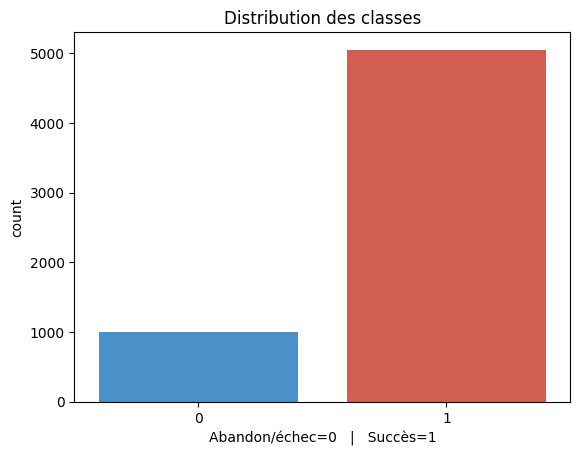

In [15]:
labels ='Abandon/échec=0   |   ' + 'Succès=1'
palette = ["#3494db", "#e74c3c"]
sns.countplot(x=etude['succes'], palette=palette)
plt.title('Distribution des classes')
plt.xlabel(labels)

## 2. Conditions

In [ ]:
#etude.Conditions = etude.Conditions.map(lambda x: "".join(ch for ch in list(x) if ch.isalnum()))
#etude.Conditions = etude.Conditions.map(lambda x: ' '.join(re.findall('[A-Z][a-z]*', x)))

In [ ]:
#etude.Conditions

In [22]:
etude.Conditions.values

array(['Respiratory Infection', 'Pemphigus Vulgaris|Pemphigus Foliaceus',
       'Complex Regional Pain Syndrome (CRPS)', ...,
       'Aneurysmal Subarachnoid Hemorrhage', 'Bipolar Disorder',
       'Diabetes Mellitus, Type 2'], dtype=object)

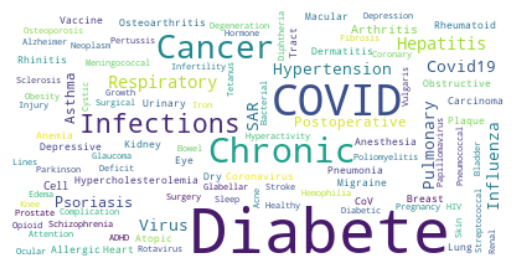

In [79]:
text = ' '.join(etude.Conditions.values)

stopwords = set(STOPWORDS)
stopwords.update(["B", "C", 'Disorders', "multiple", "moderate", "age", "induced", 'human', 'Primary', 'Failure', "Related", "mellitus", "deficiency", "stage", "dysfunction", "use", "major", "minor", "pre", "post", "infection", "diseases", "disorder", "pain", "non", "small", "type", "associated", "disease", "syndrome", "due", "acute", "severe", "high", "low"])
wordcloud = WordCloud(normalize_plurals = True, stopwords=stopwords, max_font_size=50, max_words=100, collocations = False, background_color="white", relative_scaling=1).generate(text)
#on enleve "mellitus" car c'est le nom scientifique du diabète : diabetes mellitus

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [80]:
wordcloud.words_.keys()

dict_keys(['Diabete', 'COVID', 'Chronic', 'Cancer', 'Infections', 'Respiratory', 'Hepatitis', 'Pulmonary', 'Covid19', 'Virus', 'Hypertension', 'Influenza', 'SAR', 'Psoriasis', 'Asthma', 'Postoperative', 'Arthritis', 'Cell', 'CoV', 'Osteoarthritis', 'Obstructive', 'Migraine', 'Eye', 'Depressive', 'Pneumonia', 'Hypercholesterolemia', 'Coronavirus', 'Allergic', 'Macular', 'Dermatitis', 'Anemia', 'Anesthesia', 'Lung', 'Dry', 'Kidney', 'Atopic', 'Breast', 'Urinary', 'Vaccine', 'Plaque', 'Heart', 'Rheumatoid', 'Rhinitis', 'Tract', 'Carcinoma', 'Knee', 'Bladder', 'Schizophrenia', 'Meningococcal', 'Vulgaris', 'HIV', 'Lines', 'Surgery', 'Fibrosis', 'Sclerosis', 'Pneumococcal', 'Acne', 'Prostate', 'Obesity', 'Degeneration', 'Opioid', 'Diabetic', 'Tetanus', 'Neoplasm', 'Stroke', 'Glaucoma', 'Renal', 'Bacterial', 'Diphtheria', 'Attention', 'Pertussis', 'Healthy', 'Ocular', 'Deficit', 'Parkinson', 'Depression', 'Injury', 'Skin', 'Osteoporosis', 'Growth', 'Infertility', 'Hyperactivity', 'Cystic', 'H

Les études cliniques qui ont complété la phase III (soldée par un succès ou un échec) portent principalement sur le cancer, le diabète, les maladies chroniques, l'hypertension, le SIDA, les maladies respiratoires, et les maladies mentales comme la schizophrénie ou la dépression. Explorons les caractéristiques de ces études en fonction d'autres variables. 

In [107]:
freq = list()
prob_success = list()
for condition in wordcloud.words_.keys():
    freq.append(etude[etude['Conditions'].str.contains(condition, case=False)].shape[0])
    prob_success.append(etude[etude['Conditions'].str.contains(condition, case=False)].succes.sum()/etude[etude['Conditions'].str.contains(condition, case=False)].shape[0])
freq_conditions = pd.DataFrame(data={'conditions':wordcloud.words_.keys(), 'frequencies':freq, 'prob_success': prob_success})
freq_conditions.head(50)

,conditions,frequencies,prob_success
0,Diabete,388,0.878866
1,COVID,456,0.675439
2,Chronic,266,0.830827
3,Cancer,186,0.623656
4,Infections,206,0.936893
5,Respiratory,122,0.696721
6,Hepatitis,119,0.941176
7,Pulmonary,125,0.776000
8,Covid19,128,0.773438
9,Virus,239,0.853556


In [108]:
covid = ['COVID', 'Covid19', 'CoV', 'Coronavirus']
proba_covid = etude[etude['Conditions'].str.contains('|'.join(covid), case=False)].succes.sum()/etude[etude['Conditions'].str.contains('|'.join(covid), case=False)].shape[0]


In [110]:
freq_conditions.loc[len(freq_conditions.index)] = ['COVID19', freq_conditions[freq_conditions['conditions'].isin(covid)].frequencies.sum(), proba_covid]
freq_conditions = freq_conditions[~freq_conditions['conditions'].isin(covid)]
freq_conditions = freq_conditions.sort_values(['prob_success','frequencies'], ascending=[False, False]).drop_duplicates(subset=['conditions'], keep='first')

In [113]:
freq_conditions.describe()

,frequencies,prob_success
count,97.000000,97.000000
mean,75.793814,0.846171
std,123.419503,0.122853
min,22.000000,0.428571
25%,35.000000,0.776000
50%,45.000000,0.875000
75%,70.000000,0.937500
max,1148.000000,1.000000


On remarque que les études qui portent sur les sujets les plus traités ont une probabilité de succès supérieure à 50% (en moyenne 85%)

In [256]:
etude['pop_subject']=etude.Conditions.str.contains('|'.join(freq_conditions.conditions.values))
etude.pop_subject = etude.pop_subject.astype('int')

C:\Users\zargo\AppData\Local\Temp\ipykernel_1472\2361390361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etude['pop_subject']=etude.Conditions.str.contains('|'.join(freq_conditions.conditions.values))
C:\Users\zargo\AppData\Local\Temp\ipykernel_1472\2361390361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etude.pop_subject = etude.pop_subject.astype('int')


## 3. Interventions

In [157]:
print("Les essais cliniques qui ont passé la phase III et qui font l'utilisation d'un placebo représentent " + "\033[1m" "{:.1%}".format(etude[etude.Interventions.str.contains('Placebo', case=False)].shape[0]/etude.shape[0]) + "\033[0m" + " des essais qui ont passé la phase III")

Les essais cliniques qui ont passé la phase III et qui font l'utilisation d'un placebo représentent 38.0% des essais qui ont passé la phase III


In [158]:
etude[etude.Interventions.str.contains('Placebo', case=False)].succes.value_counts()/etude.succes.value_counts()*100

succes
1    36.777514
0    44.366899
Name: count, dtype: float64

Les essais utilisant des placebos sont sous représentés parmi les essais qui ont réussi et sur représentés parmi les essais qui ont échoué

In [492]:
etude['Placebo']=etude.Interventions.str.contains('Placebo', case=False).astype('int')

C:\Users\zargo\AppData\Local\Temp\ipykernel_1472\1010926758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etude['Placebo']=etude.Interventions.str.contains('Placebo', case=False).astype('int')


In [143]:
etude.Interventions.map(lambda x: x.count('|')+1).describe()

count    6055.000000
mean        2.275805
std         1.201626
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: Interventions, dtype: float64

Les essais font intervenir en moyenne un peu plus de 2 traitements (placebo compris), le 3e quartile se situant à 3

## 4. Sponsors

In [203]:
etude.Sponsor.value_counts().describe()

count    1871.000000
mean        3.236237
std        12.499317
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       361.000000
Name: count, dtype: float64

In [260]:
sponsor_data = pd.DataFrame(etude.Sponsor.value_counts(ascending=False))
sponsor_data['public']=1*sponsor_data.index.str.contains('|'.join(['University', 'Pública', 'College', 'Institute', 'Center', 'Hospital']))
sponsor_data=pd.merge(sponsor_data, pd.DataFrame(data={'proba_success':etude.groupby('Sponsor').succes.sum()/etude.groupby('Sponsor').Bin.sum()}), left_on='Sponsor', right_on='Sponsor', how='inner')
sponsor_data=pd.merge(sponsor_data, pd.DataFrame(data={'pop_subject_ratio':etude.groupby('Sponsor').pop_subject.sum()/etude.groupby('Sponsor').Bin.sum()}), left_on='Sponsor', right_on='Sponsor', how='inner')


In [288]:
sponsor_data['proba_success'].describe()

count    1871.000000
mean        0.789802
std         0.369049
min         0.000000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: proba_success, dtype: float64

<Axes: xlabel='count', ylabel='pop_subject_ratio'>

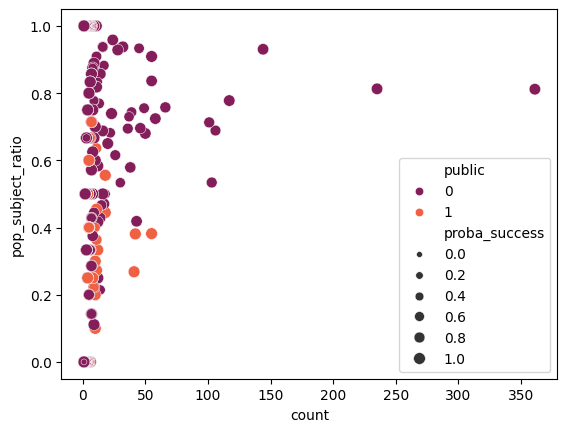

In [279]:
sns.scatterplot(data=sponsor_data, x="count", y="pop_subject_ratio", hue="public", size="proba_success", palette = 'rocket', size_norm = (0,1))

In [315]:
#afin de donner plus d'amplitude aux données on applique une fonction exponentielle, mais cela n'est pas probant
sponsor_data['exp_proba_success']=sponsor_data.proba_success.apply(lambda x: np.exp(x))

In [365]:
sponsor_data

,count,public,proba_success,pop_subject_ratio,exp_proba_success,log_proba_success
Sponsor,,,,,,
GlaxoSmithKline,361,0,0.933518,0.811634,2.543441,2.543441
Merck Sharp & Dohme LLC,235,0,0.931915,0.812766,2.539367,2.539367
Novo Nordisk A/S,144,0,0.909722,0.930556,2.483633,2.483633
Organon and Co,117,0,0.931624,0.777778,2.538628,2.538628
Novartis Pharmaceuticals,106,0,0.773585,0.688679,2.167523,2.167523
...,...,...,...,...,...,...
Eunice Kennedy Shriver National Institute of Child Health and Human Development (NICHD),1,1,1.000000,1.000000,2.718282,2.718282
Immunic AG,1,0,1.000000,0.000000,2.718282,2.718282
Clasado Biosciences Ltd,1,0,0.000000,0.000000,1.000000,1.000000


<Axes: xlabel='proba_success', ylabel='pop_subject_ratio'>

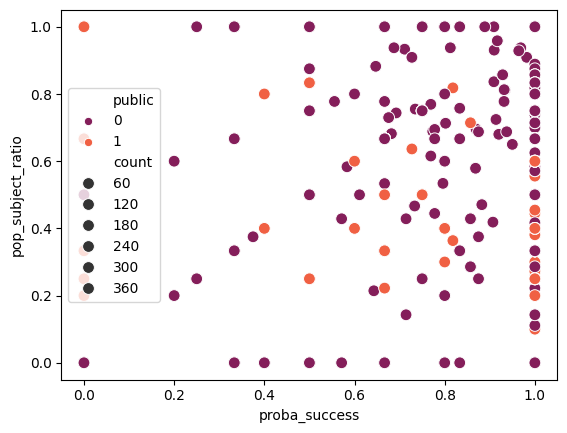

In [367]:
sns.scatterplot(data=sponsor_data, x="proba_success", y="pop_subject_ratio", hue="public", size="count", palette = 'rocket', size_norm = (0,1))

<Axes: >

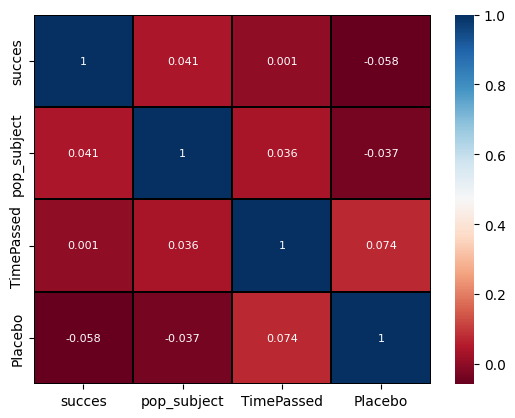

In [493]:
sns.heatmap(etude[['succes', 'pop_subject', 'TimePassed', 'Placebo']].corr(), cmap='RdBu', annot_kws={'size':8}, linecolor='black', annot = True, linewidths = 0.01)


Les corrélations sont très faibles entre nos variables quantitatives ce qui nous amène à penser qu'elles n'expliqueraient que peu le succès ou l'abandon d'un essai clinique en phase III

In [340]:
sponsor_data.drop(columns=['exp_proba_success', 'log_proba_success']).groupby('public').describe()

count                                                 proba_success  \
         count      mean        std  min  25%  50%  75%    max         count   
public                                                                         
0       1298.0  3.643297  14.774320  1.0  1.0  1.0  2.0  361.0        1298.0   
1        573.0  2.314136   3.819223  1.0  1.0  1.0  2.0   55.0         573.0   

                  ...           pop_subject_ratio                           \
            mean  ...  75%  max             count      mean       std  min   
public            ...                                                        
0       0.781875  ...  1.0  1.0            1298.0  0.554911  0.455738  0.0   
1       0.807757  ...  1.0  1.0             573.0  0.536697  0.440509  0.0   

                                 
        25%       50%  75%  max  
public                           
0       0.0  0.666667  1.0  1.0  
1       0.0  0.500000  1.0  1.0  

[2 rows x 24 columns]

Peu de différence entre les établissements publics et privés en termes de performance : pas une variable binaire à garder pour la modélisation

## 5. Collaborators

In [325]:
print("Les essais cliniques ne présentant aucune données sur les collaborateurs impliqués représentent " + "\033[1m" "{:.1%}".format(etude.Collaborators.isna().sum()/etude.shape[0]) + "\033[0m" + " des essais qui ont passé la phase III")
print("Il n'est donc pas intéressant d'étudier ce facteur")

Les essais cliniques ne présentant aucune données sur les collaborateurs impliqués représentent 79.4% des essais qui ont passé la phase III
Il n'est donc pas intéressant d'étudier ce facteur


## 6. Funder Type

In [354]:
etude['Funder Type'].isna().sum()/etude.shape[0]

0.0

In [348]:
etude.groupby('Funder Type').Sponsor.nunique()

Funder Type
FED            7
INDIV          3
INDUSTRY     894
NETWORK       16
NIH            7
OTHER        877
OTHER_GOV     66
UNKNOWN        1
Name: Sponsor, dtype: int64

In [355]:
pd.DataFrame(data = {'proba_success':etude.groupby('Funder Type').succes.sum()/etude.groupby('Funder Type').Bin.sum(), 'nb_sponsors' : etude.groupby('Funder Type').Sponsor.nunique(), 'pop_subject_ratio':etude.groupby('Funder Type').pop_subject.sum()/etude.groupby('Funder Type').Bin.sum()})
#NIH = national institutes of health

,proba_success,nb_sponsors,pop_subject_ratio
Funder Type,,,
FED,0.444444,7,0.555556
INDIV,1.000000,3,0.333333
INDUSTRY,0.846655,894,0.674716
NETWORK,0.652174,16,0.695652
NIH,0.904762,7,0.428571
OTHER,0.802987,877,0.513498
OTHER_GOV,0.913793,66,0.431034
UNKNOWN,1.000000,1,1.000000


In [357]:
etude.Locations

0       Korea University Guro Hospital, Seoul, 08308, ...
1       Investigator site 77 - US0010086, Birmingham, ...
3       US446 - Clinical Trial Connection, Cottonwood,...
4       Division of Cardiology, Yonsei Cardiovascular ...
6       Cheonan-si, Chungcheongnam-do, Korea, Republic...
                              ...                        
8352    Southern Illinois University School of Medicin...
8353     GSK Investigational Site, Wilrijk, 2610, Belgium
8354    Barrow Neurosurgical Associates, Phoenix, Ariz...
8355                                                  NaN
8356    Non-state healthcare Organization "Road Clinic...
Name: Locations, Length: 6055, dtype: object

## Sponsor reputation

En scrappant les données de clinicaltrials.gov, on peut compter le nombre d'essais cliniques recensés par le site, par sponsor. On suppose que le nombre d'essais est croissant avec le taux de succès 

In [487]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import urllib
base_url = "https://clinicaltrials.gov/search?spons="

def number_of_studies_sponsor(sponsor):
    url = base_url + urllib.parse.quote(str(sponsor))
    driver = webdriver.Chrome()
    driver.get(url)

    driver.implicitly_wait(10)

    css_selector = "#searchResultsIntro > div > p"
    selected_element = driver.find_element(By.CSS_SELECTOR, css_selector)

    if selected_element:
        element_text = selected_element.text.strip()
        return element_text
    else:
        return "Element not found"
    
    driver.quit()

In [489]:
sponsor_data['nb_studies_sponsor'] = sponsor_data.index.map(number_of_studies_sponsor)

In [490]:
sponsor_data['nb_studies_sponsor']

Sponsor
GlaxoSmithKline                                                                            Viewing 1-10 out of 4 727 studies
Merck Sharp & Dohme LLC                                                                    Viewing 1-10 out of 3 867 studies
Novo Nordisk A/S                                                                           Viewing 1-10 out of 1 478 studies
Organon and Co                                                                               Viewing 1-10 out of 492 studies
Novartis Pharmaceuticals                                                                   Viewing 1-10 out of 2 849 studies
                                                                                                         ...                
Eunice Kennedy Shriver National Institute of Child Health and Human Development (NICHD)    Viewing 1-10 out of 1 927 studies
Immunic AG                                                                                      Viewing 1-8 out of 8 

In [505]:
test_string = "Viewing 1-8 out of 8 studies"
''.join(list(filter(lambda x: x.isdigit(), test_string.split())))

'8'

In [507]:
# Define a regular expression to match the desired pattern and extract the second numeric part

# Use str.extract to extract the desired part of the pattern
sponsor_data['nb_studies_sponsor_digit'] = sponsor_data['nb_studies_sponsor'].map(lambda x: ''.join(list(filter(lambda c : c.isdigit(), x.split()))))

# Display the DataFrame with the extracted values
print(sponsor_data)


                                                    count  public  \
Sponsor                                                             
GlaxoSmithKline                                       361       0   
Merck Sharp & Dohme LLC                               235       0   
Novo Nordisk A/S                                      144       0   
Organon and Co                                        117       0   
Novartis Pharmaceuticals                              106       0   
...                                                   ...     ...   
Eunice Kennedy Shriver National Institute of Ch...      1       1   
Immunic AG                                              1       0   
Clasado Biosciences Ltd                                 1       0   
Servier                                                 1       0   
SatRx LLC                                               1       0   

                                                    proba_success  \
Sponsor                          

In [428]:
etude['nb_locations']=etude.Locations.map(lambda x: str(x).count('|')+1)

C:\Users\zargo\AppData\Local\Temp\ipykernel_1472\3031681074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etude['nb_locations']=etude.Locations.map(lambda x: str(x).count('|')+1)


In [511]:
sponsor_data

,count,public,proba_success,pop_subject_ratio,exp_proba_success,log_proba_success,nb_studies_sponsor,nb_studies_sponsor_digit
Sponsor,,,,,,,,
GlaxoSmithKline,361,0,0.933518,0.811634,2.543441,2.543441,Viewing 1-10 out of 4 727 studies,4727
Merck Sharp & Dohme LLC,235,0,0.931915,0.812766,2.539367,2.539367,Viewing 1-10 out of 3 867 studies,3867
Novo Nordisk A/S,144,0,0.909722,0.930556,2.483633,2.483633,Viewing 1-10 out of 1 478 studies,1478
Organon and Co,117,0,0.931624,0.777778,2.538628,2.538628,Viewing 1-10 out of 492 studies,492
Novartis Pharmaceuticals,106,0,0.773585,0.688679,2.167523,2.167523,Viewing 1-10 out of 2 849 studies,2849
...,...,...,...,...,...,...,...,...
Eunice Kennedy Shriver National Institute of Child Health and Human Development (NICHD),1,1,1.000000,1.000000,2.718282,2.718282,Viewing 1-10 out of 1 927 studies,1927
Immunic AG,1,0,1.000000,0.000000,2.718282,2.718282,Viewing 1-8 out of 8 studies,8
Clasado Biosciences Ltd,1,0,0.000000,0.000000,1.000000,1.000000,Viewing 1-3 out of 3 studies,3


In [515]:
etude = pd.merge(etude, sponsor_data[['public', 'nb_studies_sponsor_digit']], left_on='Sponsor', right_index=True, how='left')

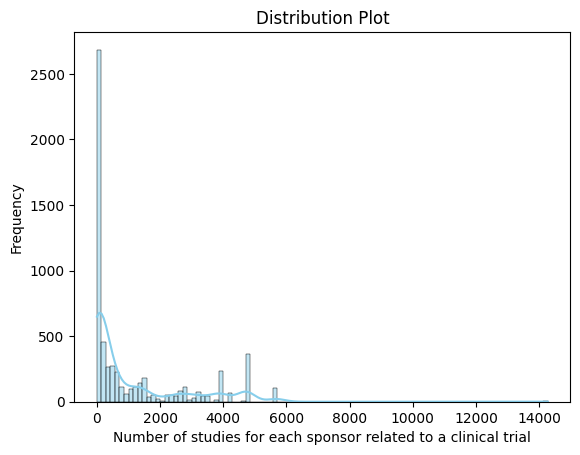

In [544]:
# Create a histogram using Seaborn
sns.histplot(data=etude, x='nb_studies_sponsor_digit', bins=100, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Number of studies for each sponsor related to a clinical trial')
plt.ylabel('Frequency')
plt.title('Distribution Plot')

# Show the plot
plt.show()

<Axes: >

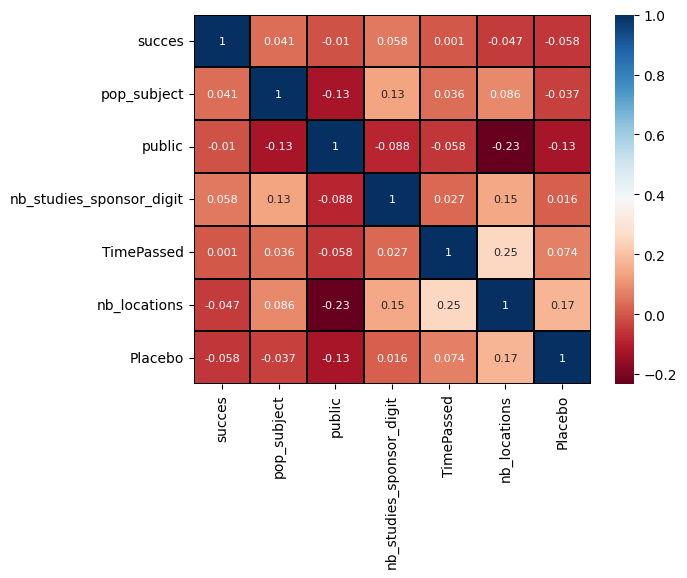

In [517]:
sns.heatmap(etude[['succes', 'pop_subject', 'public', 'nb_studies_sponsor_digit','TimePassed', 'nb_locations', 'Placebo']].corr(), cmap='RdBu', annot_kws={'size':8}, linecolor='black', annot = True, linewidths = 0.01)


### Logistic regression results

Sans appliquer de poids à la fonction de perte car les classes sont mal équilibrés (ratio de presque 1:5)

In [526]:
etude['nb_studies_sponsor_digit'] = etude['nb_studies_sponsor_digit'].astype('int')

In [527]:
etude[['nb_studies_sponsor_digit','public', 'pop_subject', 'TimePassed', 'nb_locations', 'Placebo']].dtypes

nb_studies_sponsor_digit      int32
public                        int32
pop_subject                   int32
TimePassed                  float64
nb_locations                  int64
Placebo                       int32
dtype: object

In [552]:
import statsmodels.api as sm
scaler = StandardScaler()
Xtrain = sm.add_constant(etude[['nb_studies_sponsor_digit','public', 'pop_subject', 'TimePassed', 'nb_locations', 'Placebo']])
ytrain = etude[['succes']] 

log_reg = sm.Logit(ytrain, Xtrain).fit() 


Optimization terminated successfully.
         Current function value: 0.443568
         Iterations 6


In [553]:
print(log_reg.summary()) 


                           Logit Regression Results                           
Dep. Variable:                 succes   No. Observations:                 6055
Model:                          Logit   Df Residuals:                     6048
Method:                           MLE   Df Model:                            6
Date:                Fri, 29 Dec 2023   Pseudo R-squ.:                 0.01192
Time:                        09:03:16   Log-Likelihood:                -2685.8
converged:                       True   LL-Null:                       -2718.2
Covariance Type:            nonrobust   LLR p-value:                 4.748e-12
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.5406      0.097     15.925      0.000       1.351       1.730
nb_studies_sponsor_digit     0.0001   2.45e-05      4.575      0.000    6.41e-05       0.

En appliquant un poids en utilisant "class_weights":

In [554]:
def prepare_model(data, class_col, cols_to_include):

  cols = data.select_dtypes(include=np.number).columns.tolist() 
  X = data[cols]
  X = X[X.columns.difference([class_col])] 
  X = X[cols_to_include]
  y = data[class_col]
  return train_test_split(X, y, test_size=0.25, random_state=0) #  train test split
def run_model_bweights(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression(random_state=13, class_weight='balanced') # parametre pour class_weight
    #Explication de la documentation de sklearn : The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
    logreg.fit(X_train, y_train) 
    y_pred = logreg.predict(X_test)
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test)) # ROC AUC score
    print(classification_report(y_test, y_pred)) 
    print("The area under the curve is:", logit_roc_auc) # AUC curve

In [556]:
X_train, X_test, y_train, y_test = prepare_model(etude, class_col='succes', cols_to_include=['nb_studies_sponsor_digit', 'pop_subject', 'TimePassed', 'nb_locations', 'Placebo'])
y_pred = run_model_bweights(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.21      0.61      0.32       250
           1       0.88      0.55      0.68      1264

    accuracy                           0.56      1514
   macro avg       0.55      0.58      0.50      1514
weighted avg       0.77      0.56      0.62      1514

The area under the curve is: 0.582503164556962


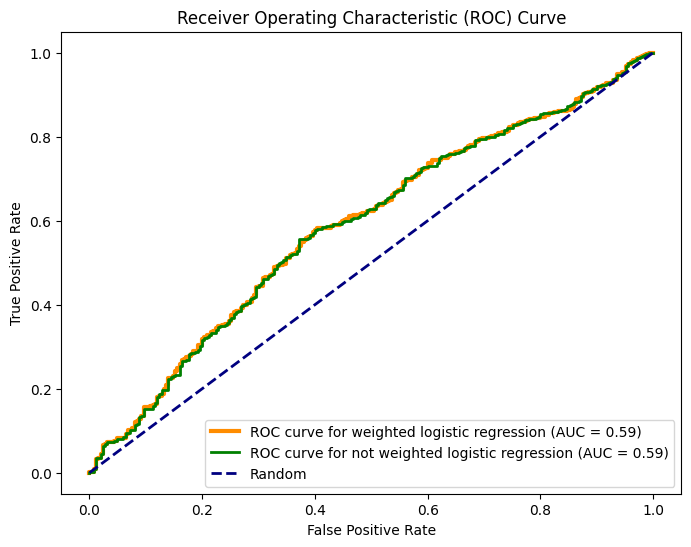

In [573]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(etude[['nb_studies_sponsor_digit', 'pop_subject', 'TimePassed', 'nb_locations', 'Placebo']], etude['succes'], test_size=0.25, random_state=0)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model and train it on the scaled data
model = LogisticRegression(random_state=13, class_weight='balanced')
model1=LogisticRegression(random_state=13)

model.fit(X_train_scaled, y_train)
model1.fit(X_train_scaled, y_train)
y_probabilities = model.predict_proba(X_test_scaled)[:, 1]
y1_probabilities = model1.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import roc_curve, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y1_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve for weighted logistic regression (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='green', lw=2, label=f'ROC curve for not weighted logistic regression (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

On n'a pas beaucoup amélioré notre modèle en prenant en compte le fait que les classes étaient déséquilibrées.